In [1]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
layers = keras.layers
models = keras.models


# This code was tested with TensorFlow v1.8
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 2.0.0-rc0


## Get the data
The data has been exported from BigQuery and is stored on GCS, and can be access directly via 

  `!gsutil cp gs://dataset-uploader/bbc/bbc-text.csv .`

It can also be accessed via https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv 

In [2]:
data = pd.read_csv("D:/Data_set/dt/bbc-text.csv")

In [3]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [7]:
data['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [5]:
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 1780
Test size: 445


## Data preparation
There's some work to be done in order for our data to be ready for training.
1. First we'll split the data into training and test sets.
1. Then we'll tokenize the words (text), and then convert them to a numbered index. 
1. Next we'll do the same for the labels (categories), by using the `LabelEncoder` utility.
1. Finally, we'll convert the labels to a one-hot representation.

In [8]:
# Use sklearn utility to convert label strings to numbered index
Y = data['category']
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y = tf.keras.utils.to_categorical(Y,num_classes=5)

#  Tokenization for model input

In [9]:
max_features=5000 #we set maximum number of words to 5000
maxlen=200 #we set maximum sequence length to 400

In [10]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features) #again tokenizer step

In [11]:
tok.fit_on_texts(list(data['text'])) #fit to cleaned text

In [12]:
print(len(tok.word_index))
vocab_size = len(tok.word_index) + 1 

29726


In [13]:
train_df = tok.texts_to_sequences(list(data['text'])) #this is how we create sequences
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen) #let's execute pad step

In [14]:
# Train test split
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_df, Y, test_size=0.1, random_state=42)

## Train the model

Build the model using Keras layers and hyperparameters of your choosing. Then call `model.fit()`

In [19]:
embedding_dim = 50 
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           input_length=maxlen), 
  tf.keras.layers.Flatten(), #flatten layer

  tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           1486350   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 50005     
Total params: 1,536,355
Trainable params: 1,536,355
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(np.array(X_train), np.array(y_train), epochs=20)

Train on 2002 samples
Epoch 1/20
2002/2002 [==============================] - 3s 2ms/sample - loss: 1.5372 - accuracy: 0.3941
Epoch 2/20
2002/2002 [==============================] - 1s 691us/sample - loss: 0.9110 - accuracy: 0.8911
Epoch 3/20
2002/2002 [==============================] - 1s 689us/sample - loss: 0.2685 - accuracy: 0.9860
Epoch 4/20
2002/2002 [==============================] - 1s 692us/sample - loss: 0.0883 - accuracy: 0.9980
Epoch 5/20
2002/2002 [==============================] - 1s 694us/sample - loss: 0.0402 - accuracy: 1.0000
Epoch 6/20
2002/2002 [==============================] - 1s 709us/sample - loss: 0.0232 - accuracy: 1.0000
Epoch 7/20
2002/2002 [==============================] - 1s 747us/sample - loss: 0.0153 - accuracy: 1.0000
Epoch 8/20
2002/2002 [==============================] - 1s 722us/sample - loss: 0.0110 - accuracy: 1.0000
Epoch 9/20
2002/2002 [==============================] - 1s 694us/sample - loss: 0.0083 - accuracy: 1.0000
Epoch 10/20
2002/2002 [===


## Evaluate the model
Evaluation is easy. Just call `model.evaluate()`.

In [25]:
# Evaluate the accuracy of our trained model
score = model.evaluate(X_test, y_test,
                       batch_size=10, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

223/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Hyperparameter tuning

This is a good time to go back and tweak some parameters such as `epoch`, `batch size`, `dropout ratio`, network structure, activation function, and others, to see if you can improve the accuracy.

In this particular case, to make it more challenging, I recommend reducing the max words of the call to `keras.preprocessing.text.Tokenizer`. This will reduce the number of words for each input sample, thus making it more challenging to accurately predict the category. (Notice that not all hyperparameters are necessarily inside the model. This is one such example.)

The default was up to 1000 words per article. See what happens when you reduce that number to 200 words, or 50 words, or even fewer. As the evaluation accuracy drops, the effects of your hyperparameter tuning will be more pronounced, with successful adjustments making meaningful improvements to the model performance.

To make this process easier to manage, I've encapulated the model definition and training and evaluation calls into one function call. You can add additional parameters as needed.

###Hyperparameter Search

You can also automate this process using for-loops and more sophiscated methods of deciding which combinations of hyperparameter values to try out.

Exhaustive search is generally not the most elegant way, this is mostly just for illustrative purposes.

## Make some predictions
Take some samples from the test dataset and inspect some individual predictions, to ensure that things are sensible.


## (optional) Extra extra! Visualize the confusion matrix
This can help identify which areas were a challenge to get right, if the model is performing poorly.

In [30]:
text_labels = encoder.classes_ 
y_softmax = model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [31]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

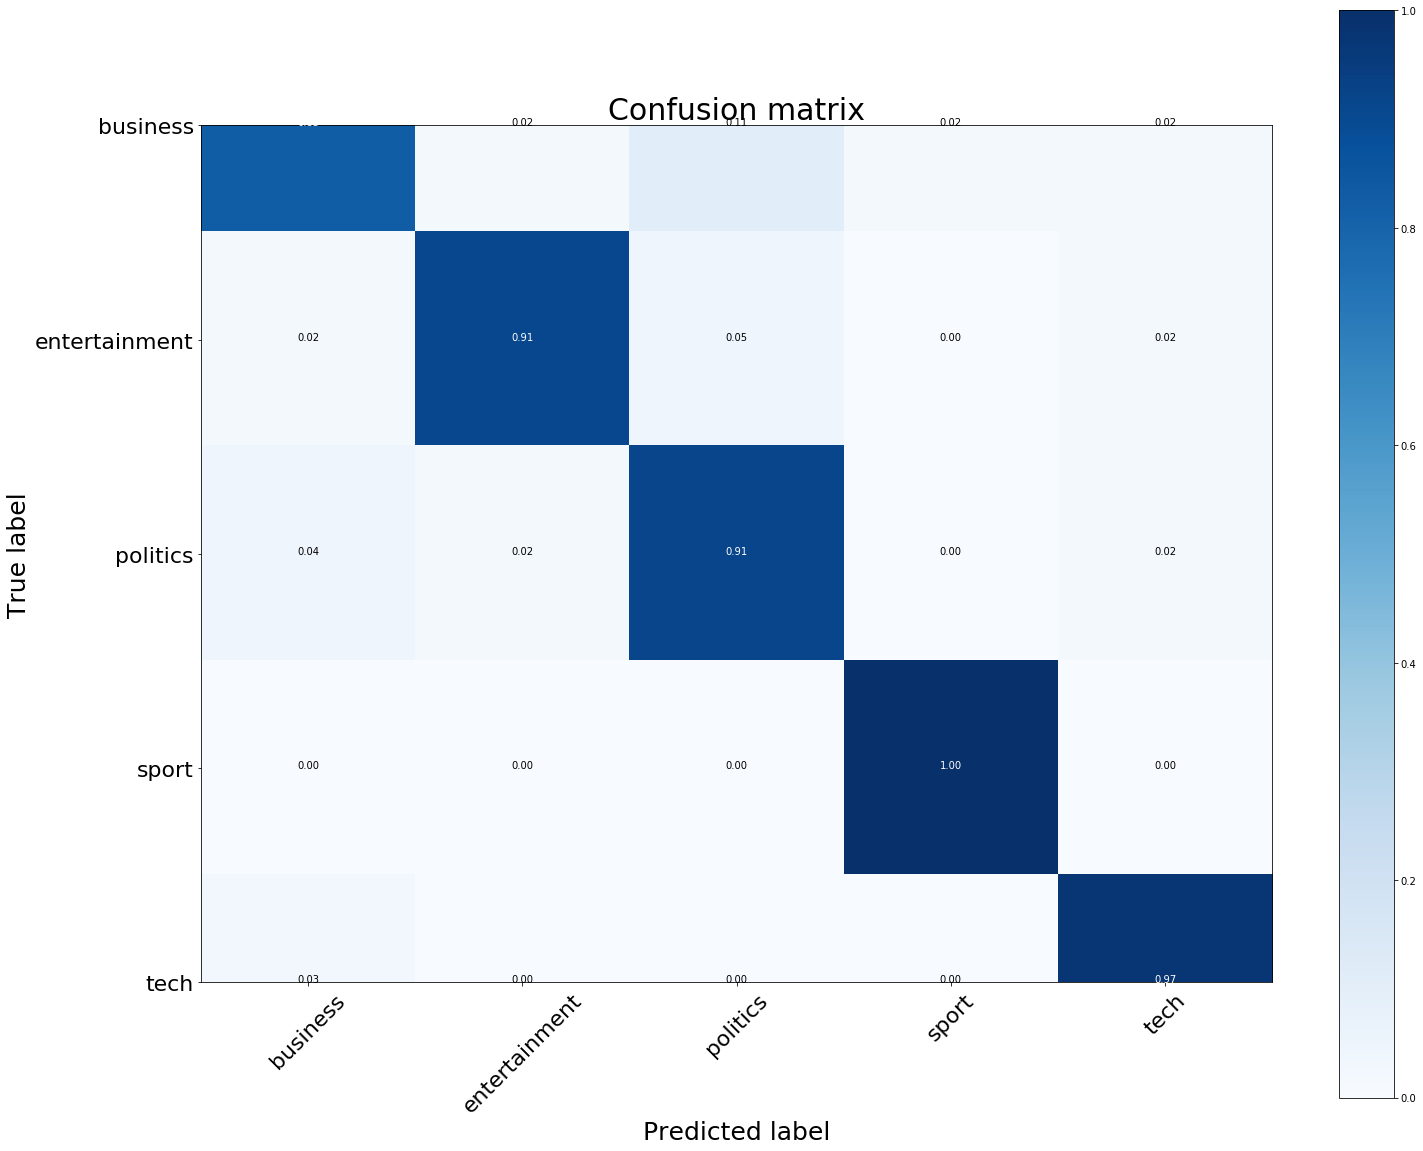

In [32]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## precession Recall

In [33]:
from sklearn import metrics

In [35]:
print(metrics.classification_report(y_test_1d, y_pred_1d, digits=5))

              precision    recall  f1-score   support

           0    0.90476   0.82609   0.86364        46
           1    0.95238   0.90909   0.93023        44
           2    0.86000   0.91489   0.88660        47
           3    0.97959   1.00000   0.98969        48
           4    0.92500   0.97368   0.94872        38

    accuracy                        0.92377       223
   macro avg    0.92435   0.92475   0.92378       223
weighted avg    0.92428   0.92377   0.92325       223

